<a href="https://colab.research.google.com/github/NathanG2022/Fencing-Lunge/blob/main/Nathan_Lunge_AI_Analysis_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing a Fencing Lunge with Machine Learning

In this notebook you use the Video Intelligence API to analyze a fencing lunge, including the angle of the arms and legs during the lunge.

## Setup

First, install the necessary libraries. The first cell will download and install the libraries onto the notebook, and the next cell imports them.

In [ ]:
!pip install google-cloud-automl

You might have to restart your runtime to load these packages.

In [ ]:
import sys
import os
import json
import math

import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import automl
from google.cloud import videointelligence_v1p3beta1 as videointelligence
from google.oauth2 import service_account

Fill in your info below by specifying your project id and bucket name. Replace YOUR_PROJECT_ID with your Qwiklabs Project ID.

In [ ]:
project_id = 'nathan-lunge'  #@param {type: "string"}
bucket = 'gs://nathan-lunge-bucket' #@param {type: "string"}
!gcloud config list project

[core]
project = nathan-lunge

Your active configuration is: [default]


Next, create your bucket, enable the video intelligence and AutoML APIs, and generate a service account key to access the AutoML API. For this lab, you will use your autogenerated Qwiklabs Service Account.

In [ ]:
!gcloud config set project {project_id}
!gsutil mb {bucket}
!gcloud config set project nathan-lunge
!gcloud iam service-accounts keys create ./key.json --iam-account {project_id}@{project_id}.iam.gserviceaccount.com

# Enable the Video Intelligence API and AutoML
!gcloud services enable videointelligence.googleapis.com
!gcloud services enable automl.googleapis.com

Updated property [core/project].
Creating gs://nathan-lunge-bucket/...
ServiceException: 409 A Cloud Storage bucket named 'nathan-lunge-bucket' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
Updated property [core/project].
created key [598c1515c0c28b65d3f5fc572ef081ca69e125de] of type [json] as [./key.json] for [nathan-lunge@nathan-lunge.iam.gserviceaccount.com]


In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"

## Using the Video Intelligence API

In this section you will analyze a skeleton using the Video Intelligence API. Using Person Detection, the Video Intelligence API can detect the presence of humans in a video file and track the bounding box of individual people across the video or video segment. Person Detection recognizes a handful of body parts, facial features, and clothing as "landmarks". A table from the documentation:

<div>
<img src="https://daleonai.com/images/screen-shot-2020-07-14-at-3-45-56-pm.png" width="800"/>
</div>

The API tracks all sorts of features, including facial features. For this lab you will only focus on the body.

In [ ]:
input_uri = "gs://nathan-lunge-bucket/nathan_lunge.MOV"

Now, run the Video Intelligence API's Person Detection feature on the video from the bucket. This function takes an input path to your video.

In [ ]:
# This function comes from the docs
# https://cloud.google.com/video-intelligence/docs/people-detection
def detect_person(input_uri):
    """Detects people in a video."""

    client = videointelligence.VideoIntelligenceServiceClient(credentials=service_account.Credentials.from_service_account_file(
    './key.json'))

    # Configure the request
    config = videointelligence.types.PersonDetectionConfig(
        include_bounding_boxes=True,
        include_attributes=True,
        include_pose_landmarks=True,
    )
    context = videointelligence.types.VideoContext(person_detection_config=config)

    # Start the asynchronous request
    operation = client.annotate_video(
        request={
            "features": [videointelligence.Feature.PERSON_DETECTION],
            "input_uri": input_uri,
            "video_context": context,
        }
    )

    print("\nProcessing video for person detection annotations.")
    result = operation.result(timeout=300)
    print("\nAnnotation complete!")

    return result


In [ ]:
operation = detect_person(input_uri)


Processing video for person detection annotations.

Annotation complete!


It takes a minute or two for the entire video to be analyzed. Wait for your `detect_person` function to complete and print the `Annotation complete!` message before moving on.

## Formatting the Data

Results are saved as an `AnnotateVideoResponse` object which you can

These results are usually pretty big, so don't print them! Instead, inspect the structure:

In [ ]:
# You only care about annotation_results[0] because you only have one video
print(len(operation.annotation_results[0].person_detection_annotations))

1


It's easy to get lost in all of these nested fields, but the important data for this lab is stored in `operation.annotation_results[0].person_detection_annotations`. Store it in `people_annotations`:

In [ ]:
people_annotations = operation.annotation_results[0].person_detection_annotations

In `people_annotations`, every entry corresponds to a person, and each person has a unique set of `tracks`, or tracked segments. Write a helper function to parse through the data and rearrange it to make it easier to use:

In [ ]:
'''
This helper function takes in a person and rearranges the data so it's in
a timeline, which will make it easier for us to work with
'''
def analyzePerson(person):
  frames = []
  for track in person.tracks:
    # Convert timestamps to seconds
    for ts_obj in track.timestamped_objects:
      time_offset = ts_obj.time_offset
      timestamp = time_offset.seconds + time_offset.microseconds / 1e6
      frame= {'timestamp' : timestamp}
      for landmark in ts_obj.landmarks:
        frame[landmark.name + '_x'] = landmark.point.x
        # Subtract y value from 1 because positions are calculated
        # from the top left corner
        frame[landmark.name + '_y'] = 1 - landmark.point.y
      frames.append(frame)
  sorted(frames, key=lambda x: x['timestamp'])
  return frames

Next, store the data in a pandas DataFrame (also for convenience), and sort each data point by timestamp:

In [ ]:
annotationsPd = pd.DataFrame()
for annotation in people_annotations:
  annotationsPd = annotationsPd.append(pd.DataFrame(analyzePerson(annotation)))

annotationsPd = annotationsPd.sort_values('timestamp', ascending=True)

Now, take a look at the results!

In [ ]:
annotationsPd.head()

,timestamp,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.0,0.674277,0.803195,0.683403,0.823424,0.667433,0.819378,0.703936,0.835561,0.660589,...,0.694810,0.511893,0.792912,0.301509,0.612678,0.370288,0.856792,0.163950,0.656026,0.196317
1,0.1,0.674243,0.803090,0.683368,0.823318,0.667399,0.819272,0.703900,0.839500,0.660556,...,0.694775,0.511812,0.792868,0.301444,0.612649,0.370218,0.856743,0.163895,0.655993,0.196260
2,0.2,0.674236,0.803041,0.683361,0.823268,0.667393,0.819222,0.703891,0.839449,0.660550,...,0.694767,0.511775,0.792856,0.301416,0.612645,0.374233,0.856729,0.163874,0.655987,0.196237
3,0.3,0.674237,0.803041,0.683362,0.823267,0.667394,0.819222,0.703892,0.839449,0.660550,...,0.694768,0.511775,0.792857,0.301416,0.612646,0.374233,0.856729,0.163874,0.655988,0.196237
4,0.4,0.674409,0.802947,0.683529,0.823163,0.667569,0.819120,0.704049,0.839336,0.658450,...,0.694929,0.511834,0.792967,0.301586,0.612850,0.374364,0.856806,0.164116,0.656170,0.196462


As you can see above, the data is organized by the position of each body part by timestamp. Note: this works because there is only one person in the video used for this lab.

## Plotting the Data

With the video data formatted, plot the positions of the wrists and try to determine the start and end time of a lunge:

<Figure size 432x288 with 0 Axes>

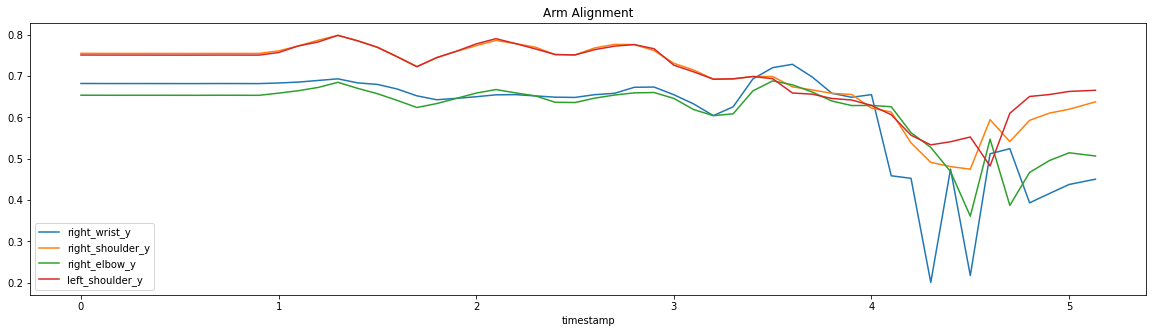

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_wrist_y', 'right_shoulder_y', 'right_elbow_y', 'left_shoulder_y'], figsize=(20, 5))
plt.title("Arm Alignment")
plt.savefig("arm_align")

<Figure size 432x288 with 0 Axes>

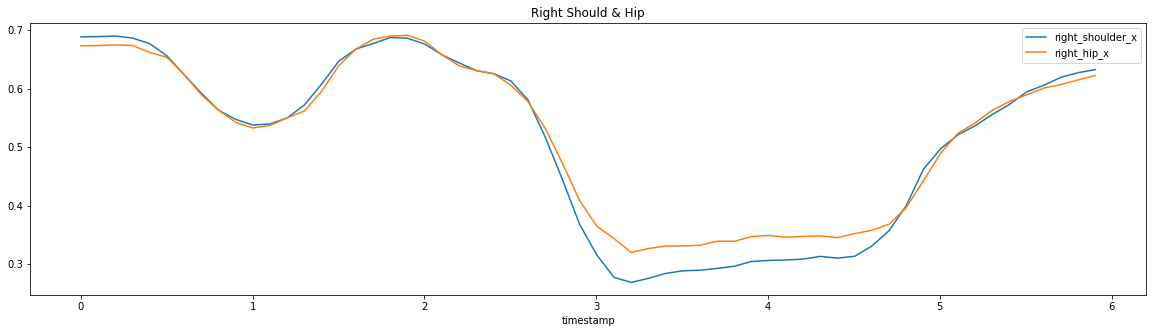

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_shoulder_x', 'right_hip_x'], figsize=(20, 5))
plt.title("Right Should & Hip")
plt.savefig("right_shoulder_hip")

<Figure size 432x288 with 0 Axes>

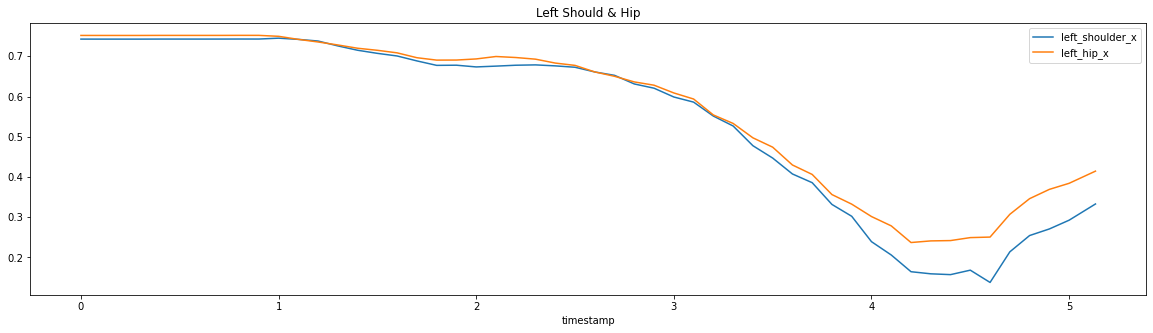

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['left_shoulder_x', 'left_hip_x'], figsize=(20, 5))
plt.title("Left Should & Hip")
plt.savefig("left_shoulder_hip")

<Figure size 432x288 with 0 Axes>

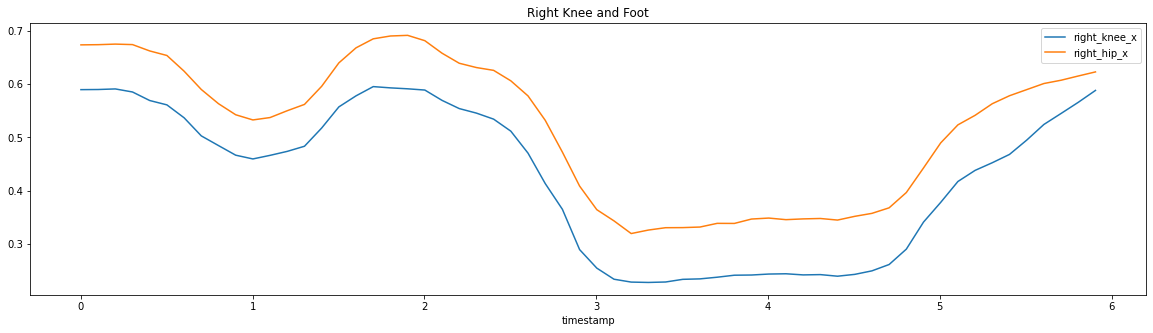

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_knee_x', 'right_hip_x'], figsize=(20, 5))
plt.title("Right Knee and Foot")
plt.savefig("right_knee_foot")

From the plot above, you can actually identify the time of a lunge pretty easily! First, the lunge starts (peak in left wrist/blue line). Then, a few seconds later, the lunge ends (peak in right wrist/orange line).

The above plot is useful, but what would be even better would be understanding the angles of the elbow, knee, etc., in relation to the positions of the wrists.

## Computing Angles
Step 1: Create some classes for making working with points easier:

In [ ]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y

To compute the angle made by three points, use the [Law of Cosines](https://www.google.com/search?q=rule+of+cosines&oq=rule+of+cosines&aqs=chrome.0.0l8.1048j1j7&sourceid=chrome&ie=UTF-8#wptab=s:H4sIAAAAAAAAAONgVuLQz9U3SMkuLnjE6Mgt8PLHPWEpi0lrTl5jNOLiCs7IL3fNK8ksqRRS4WKDsqS4eKTgmjQYpLi44DyeXUyCzvl5yakFJc6JOcmlOYkl-UWLWCV9EssV8tMUkvOLM_NSixWS4XIALyw914AAAAA). Imagine a triangle with side lengths a, b, and c. Then, to find 𝛾 (the angle across from side c), the formula is:

\begin{equation*}
\gamma = \cos^{-1}\frac{a^2+b^2 - c^2}{2ab}
\end{equation*}

The math is provided for you in this lab, but if it feels a bit confusing, there's a good explanation and code sample [here](https://medium.com/@manivannan_data/find-the-angle-between-three-points-from-2d-using-python-348c513e2cd), from which this function is borrowed:

In [ ]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c.y-b.y, c.x-b.x) - math.atan2(a.y-b.y, a.x-b.x))
    return ang

Using the `point` class and `getAngle` method, compute some useful angles below:

In [ ]:
def computeRightElbowAngle(row, which='right'):
  wrist = Point(row[f'{which}_wrist_x'], row[f'{which}_wrist_y'])
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  return getAngle(wrist, elbow, shoulder)

def computeRightShoulderAngle(row, which='right'):
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  return getAngle(hip, shoulder, elbow)

def computeLeftShoulderAngle(row, which='left'):
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  return getAngle(hip, shoulder, elbow)

def computeRightKneeAngle(row, which='right'):
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  knee = Point(row[f'{which}_knee_x'], row[f'{which}_knee_y'])
  ankle = Point(row[f'{which}_ankle_x'], row[f'{which}_ankle_y'])
  return getAngle(ankle, knee, hip)

def computeLeftKneeAngle(row, which='left'):
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  knee = Point(row[f'{which}_knee_x'], row[f'{which}_knee_y'])
  ankle = Point(row[f'{which}_ankle_x'], row[f'{which}_ankle_y'])
  return getAngle(ankle, knee, hip)



In [ ]:
# For a single timeslot...
row = annotationsPd.iloc[-1]
print("Right Elbow angle: " + str(computeRightElbowAngle(row)))
print("Right Shoulder angle: " + str(computeRightShoulderAngle(row)))
print("Left Shoulder angle: " + str(computeLeftShoulderAngle(row)))
print("Right Knee angle: " + str(computeRightKneeAngle(row)))
print("Left Knee angle: " + str(computeLeftKneeAngle(row)))

Right Elbow angle: 225.21689095708723
Right Shoulder angle: -21.245866986160536
Left Shoulder angle: 26.997341638353138
Right Knee angle: 131.89518136706485
Left Knee angle: 151.15931118306617


Now, plot those angles over time.

In [ ]:
annotationsPd['right_elbow_angle'] = annotationsPd.apply(computeRightElbowAngle, axis=1)
annotationsPd['right_shoulder_angle'] = annotationsPd.apply(computeRightShoulderAngle, axis=1)
annotationsPd['right_knee_angle'] = annotationsPd.apply(computeRightKneeAngle, axis=1)
annotationsPd['left_shoulder_angle'] = annotationsPd.apply(computeLeftShoulderAngle, axis=1)
annotationsPd['left_knee_angle'] = annotationsPd.apply(computeLeftKneeAngle, axis=1)

Next, plot the results!

<Figure size 432x288 with 0 Axes>

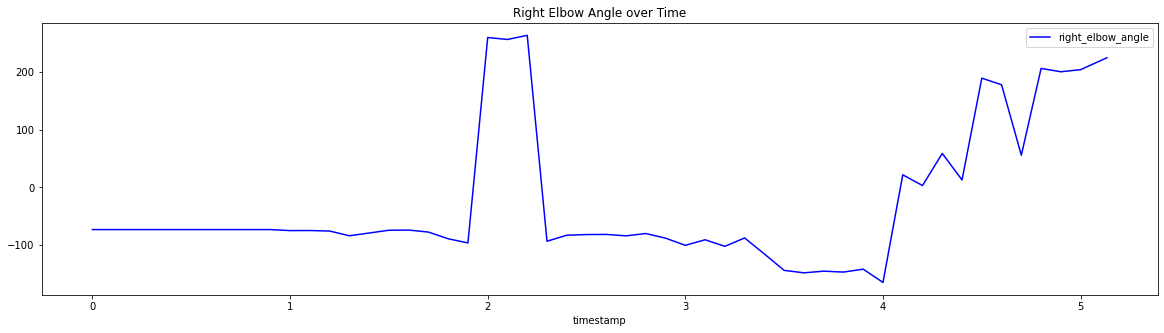

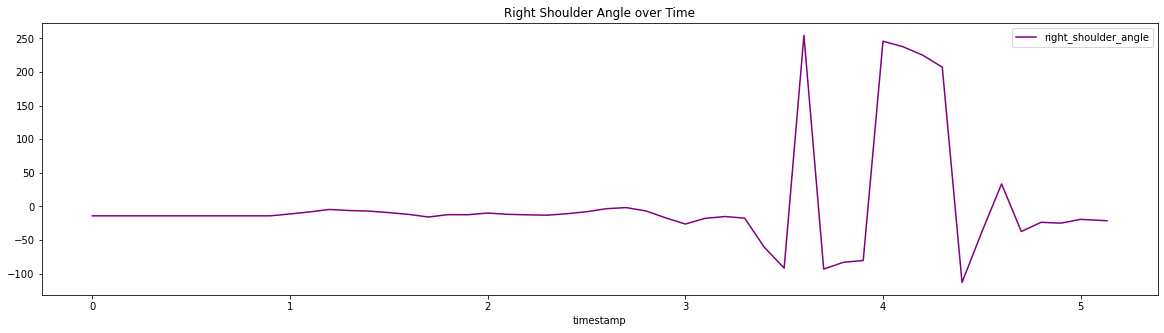

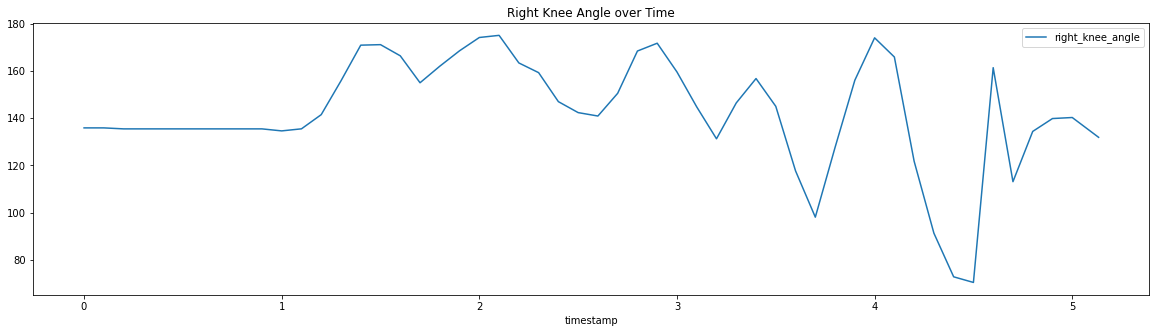

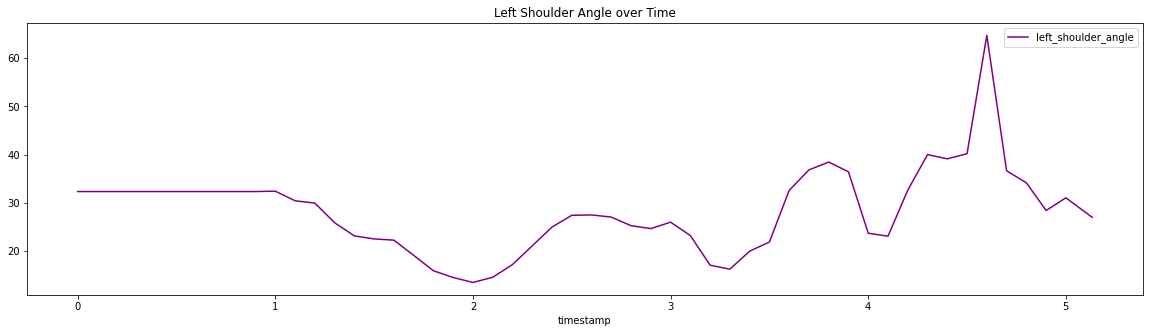

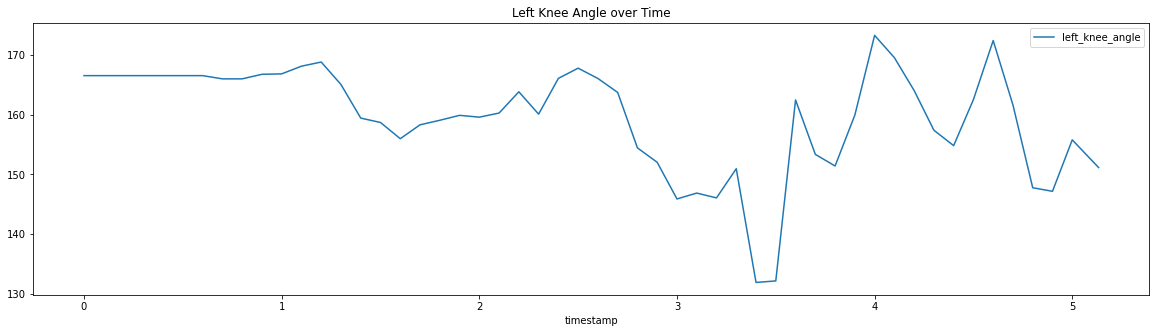

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), color='blue')
plt.title("Right Elbow Angle over Time")
plt.savefig("right_elbow_angle")
annotationsPd.plot('timestamp', ['right_shoulder_angle'], figsize=(20, 5), color='purple')
plt.title("Right Shoulder Angle over Time")
plt.savefig("right_shoulder_angle")
annotationsPd.plot('timestamp', ['right_knee_angle'], figsize=(20, 5))
plt.title("Right Knee Angle over Time")
plt.savefig("right_knee_angle")
annotationsPd.plot('timestamp', ['left_shoulder_angle'], figsize=(20, 5), color='purple')
plt.title("Left Shoulder Angle over Time")
plt.savefig("left_shoulder_angle")
annotationsPd.plot('timestamp', ['left_knee_angle'], figsize=(20, 5))
plt.title("Left Knee Angle over Time")
plt.savefig("left_knee_angle")

These angles might not be very useful on their own, but when combined with position data, you can tell what the angle of the arm was _at the height of the lunge_. In particular, take a look at the angle of the elbow and shoulder when the right wrist was at the start of the lunge:

<AxesSubplot:label='2', xlabel='timestamp'>

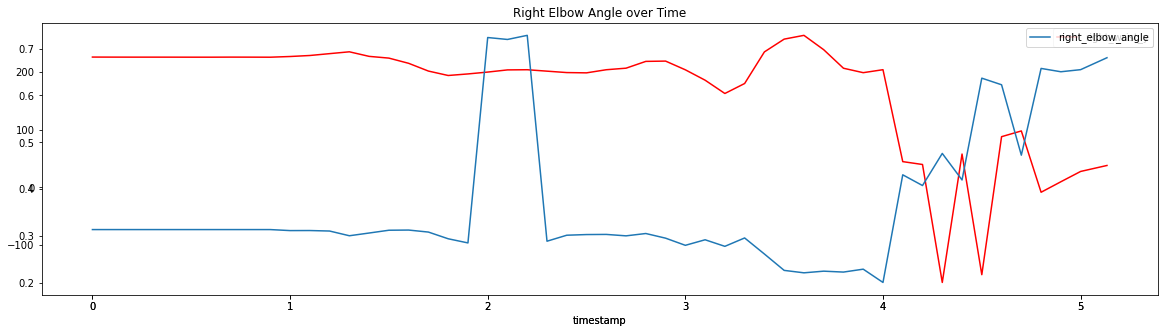

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(111, label="1")
annotationsPd.plot('timestamp', ['right_wrist_y'], figsize=(20, 5), ax=ax, color='red')
plt.title("Right Elbow Angle over Time")

ax2=fig.add_subplot(111, label="2", frame_on=False)
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), ax=ax2)

#annotationsPd.plot.scatter('right_wrist_y', 'right_elbow_angle')

These charts might be difficult to read, but but they show that the elbow is at a 200 degree angle when the arm is most extended. In an ideal lunge, the elbow would be straight when the arm is most extended.

# Analyze the Olympic Champion's Lunge

Now let's anaylize Olympic chamion Siklosi's lunge

To make a prediction with AutoML, first convert the video of fencing lunges into images. Download the video from the public bucket:

In [ ]:
input_uri = "gs://nathan-lunge-bucket/SIKLOSI_Lunge2.mp4"
operation = detect_person(input_uri)
print(len(operation.annotation_results[0].person_detection_annotations))
people_annotations = operation.annotation_results[0].person_detection_annotations


Processing video for person detection annotations.

Annotation complete!
1


Use the `ffmpeg` command to generate snapshots from the lunge video at 20 frames per second. The `-t` flag of this command specifies a 2 second segment (`-t 00:00:02`) that starts from one second in (`-ss 00:00:01`). This should align with the first lunge.

In [ ]:
annotationsPd = pd.DataFrame()
for annotation in people_annotations:
  annotationsPd = annotationsPd.append(pd.DataFrame(analyzePerson(annotation)))

annotationsPd = annotationsPd.sort_values('timestamp', ascending=True)
annotationsPd.head()

,timestamp,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.0,0.674277,0.803195,0.683403,0.823424,0.667433,0.819378,0.703936,0.835561,0.660589,...,0.694810,0.511893,0.792912,0.301509,0.612678,0.370288,0.856792,0.163950,0.656026,0.196317
1,0.1,0.674243,0.803090,0.683368,0.823318,0.667399,0.819272,0.703900,0.839500,0.660556,...,0.694775,0.511812,0.792868,0.301444,0.612649,0.370218,0.856743,0.163895,0.655993,0.196260
2,0.2,0.674236,0.803041,0.683361,0.823268,0.667393,0.819222,0.703891,0.839449,0.660550,...,0.694767,0.511775,0.792856,0.301416,0.612645,0.374233,0.856729,0.163874,0.655987,0.196237
3,0.3,0.674237,0.803041,0.683362,0.823267,0.667394,0.819222,0.703892,0.839449,0.660550,...,0.694768,0.511775,0.792857,0.301416,0.612646,0.374233,0.856729,0.163874,0.655988,0.196237
4,0.4,0.674409,0.802947,0.683529,0.823163,0.667569,0.819120,0.704049,0.839336,0.658450,...,0.694929,0.511834,0.792967,0.301586,0.612850,0.374364,0.856806,0.164116,0.656170,0.196462


For ease of use, store the snapshots in a variable and sort them:

<Figure size 432x288 with 0 Axes>

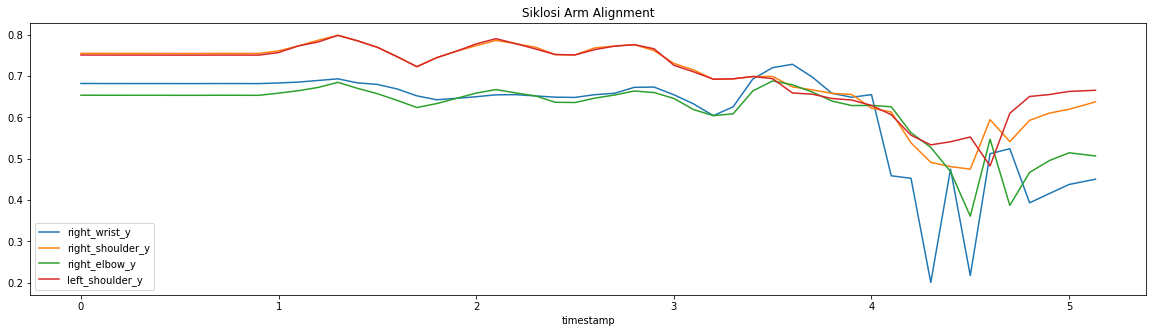

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_wrist_y', 'right_shoulder_y', 'right_elbow_y', 'left_shoulder_y'], figsize=(20, 5))
plt.title("Siklosi Arm Alignment")
plt.savefig("s-arm_align")

Now, upload these snapshots back into your bucket so that they will be easy to use in the Cloud Run prediction request:

<Figure size 432x288 with 0 Axes>

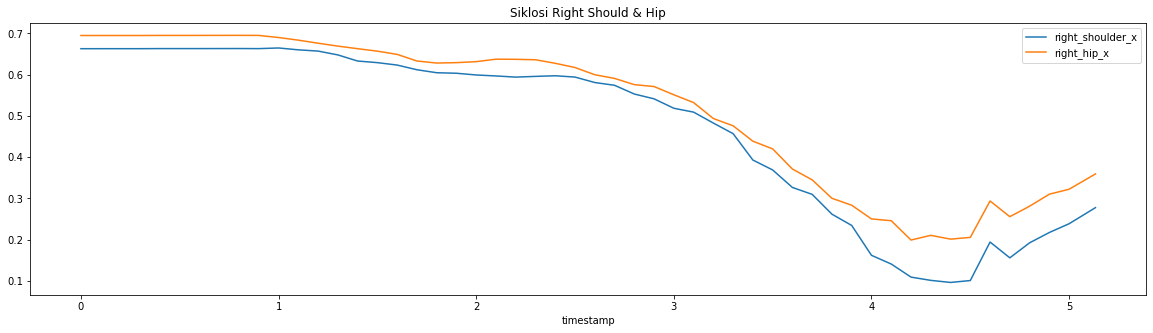

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_shoulder_x', 'right_hip_x'], figsize=(20, 5))
plt.title("Siklosi Right Should & Hip")
plt.savefig("s-right_shoulder_hip")

<Figure size 432x288 with 0 Axes>

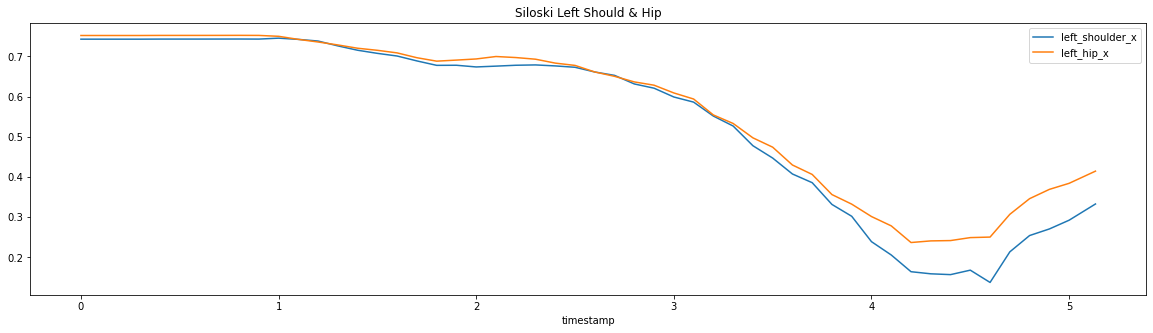

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['left_shoulder_x', 'left_hip_x'], figsize=(20, 5))
plt.title("Siloski Left Should & Hip")
plt.savefig("s-left_shoulder_hip")

<Figure size 432x288 with 0 Axes>

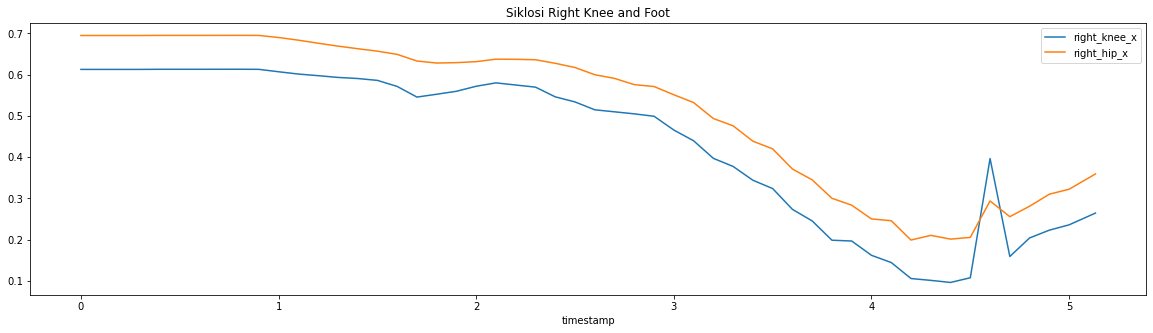

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_knee_x', 'right_hip_x'], figsize=(20, 5))
plt.title("Siklosi Right Knee and Foot")
plt.savefig("s-right_knee_foot")

Next, write the prediction function which uses the AutoML model to analyze those snapshots. In order to do that, you will need a valid ID token to access the pretrained model.

Access your student ID token by logging in to [this authentication page](https://gsp-auth-kjyo252taq-uc.a.run.app/) with your student email address and password.

Once logged in click the __Copy__ button, paste it into this id_token variable and run the cell:

In [ ]:
# For a single timeslot...
row = annotationsPd.iloc[-1]
print("Right Elbow angle: " + str(computeRightElbowAngle(row)))
print("Right Shoulder angle: " + str(computeRightShoulderAngle(row)))
print("Left Shoulder angle: " + str(computeLeftShoulderAngle(row)))
print("Right Knee angle: " + str(computeRightKneeAngle(row)))
print("Left Knee angle: " + str(computeLeftKneeAngle(row)))

Right Elbow angle: 225.21691229214173
Right Shoulder angle: -21.245864125158676
Left Shoulder angle: 26.997328196125217
Right Knee angle: 131.89510228452204
Left Knee angle: 151.15926612381205


In [ ]:
annotationsPd['right_elbow_angle'] = annotationsPd.apply(computeRightElbowAngle, axis=1)
annotationsPd['right_shoulder_angle'] = annotationsPd.apply(computeRightShoulderAngle, axis=1)
annotationsPd['right_knee_angle'] = annotationsPd.apply(computeRightKneeAngle, axis=1)
annotationsPd['left_shoulder_angle'] = annotationsPd.apply(computeLeftShoulderAngle, axis=1)
annotationsPd['left_knee_angle'] = annotationsPd.apply(computeLeftKneeAngle, axis=1)

<Figure size 432x288 with 0 Axes>

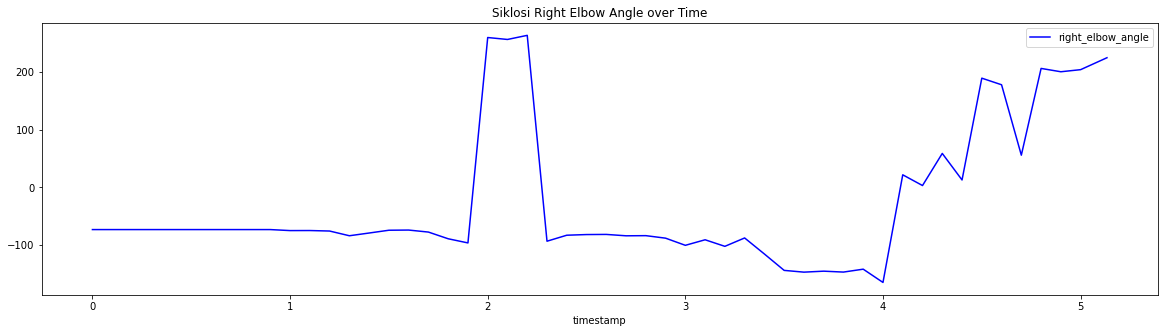

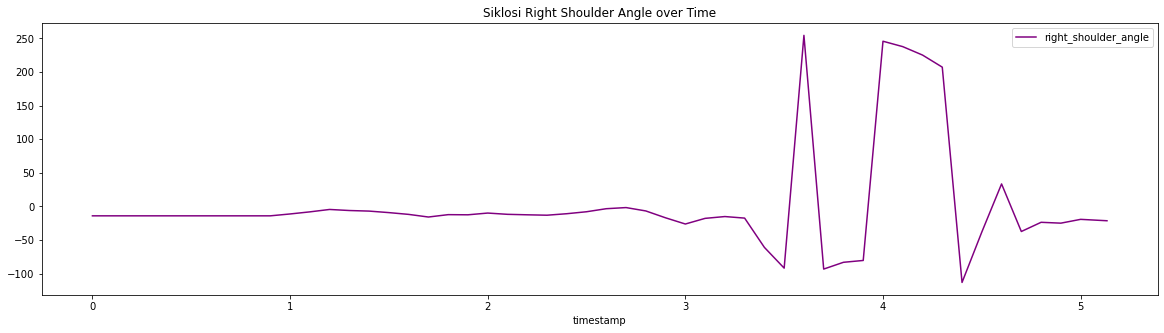

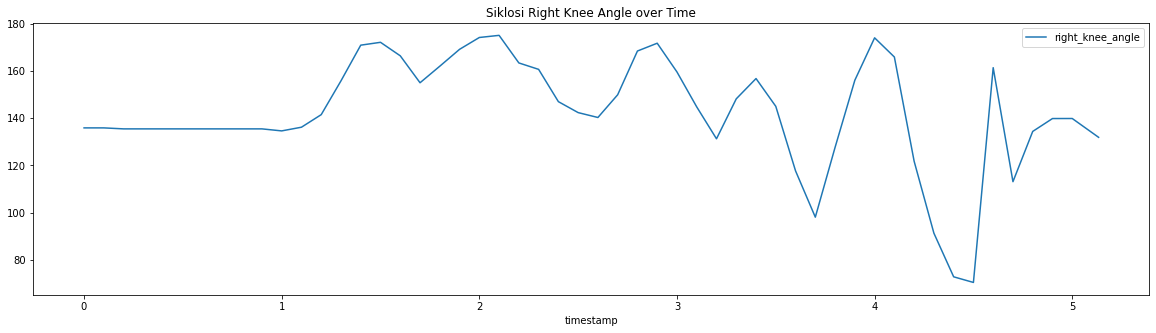

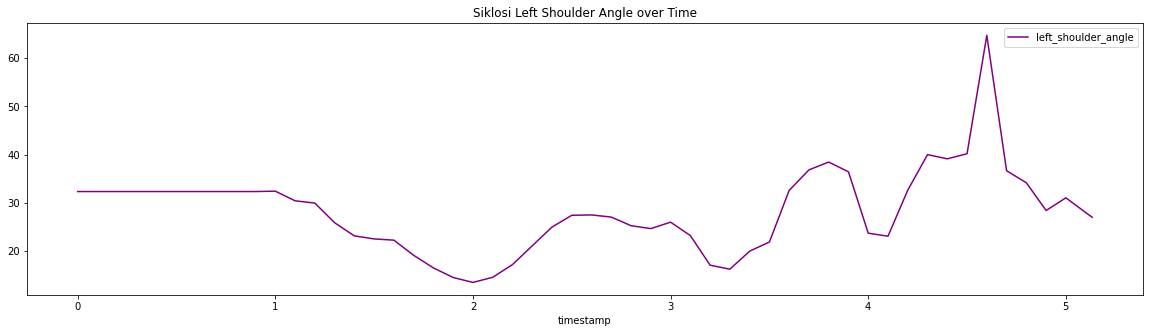

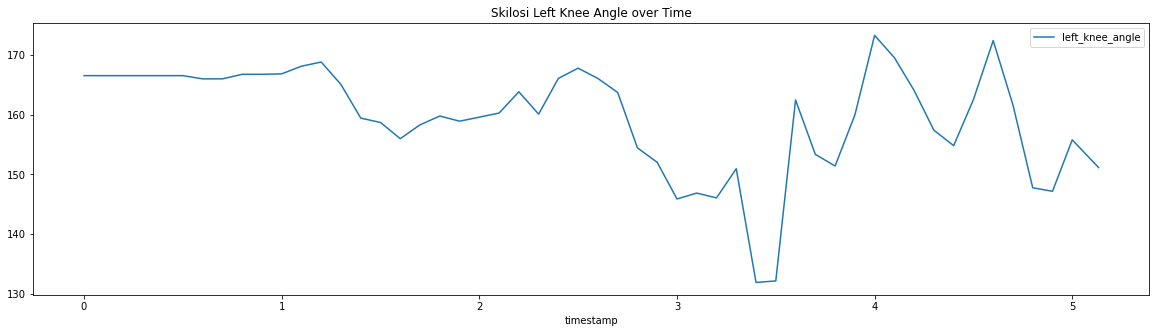

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), color='blue')
plt.title("Siklosi Right Elbow Angle over Time")
plt.savefig("s-right_elbow_angle")
annotationsPd.plot('timestamp', ['right_shoulder_angle'], figsize=(20, 5), color='purple')
plt.title("Siklosi Right Shoulder Angle over Time")
plt.savefig("s-right_shoulder_angle")
annotationsPd.plot('timestamp', ['right_knee_angle'], figsize=(20, 5))
plt.title("Siklosi Right Knee Angle over Time")
plt.savefig("s-right_knee_angle")
annotationsPd.plot('timestamp', ['left_shoulder_angle'], figsize=(20, 5), color='purple')
plt.title("Siklosi Left Shoulder Angle over Time")
plt.savefig("s-left_shoulder_angle")
annotationsPd.plot('timestamp', ['left_knee_angle'], figsize=(20, 5))
plt.title("Skilosi Left Knee Angle over Time")
plt.savefig("s-left_knee_angle")

<AxesSubplot:label='2', xlabel='timestamp'>

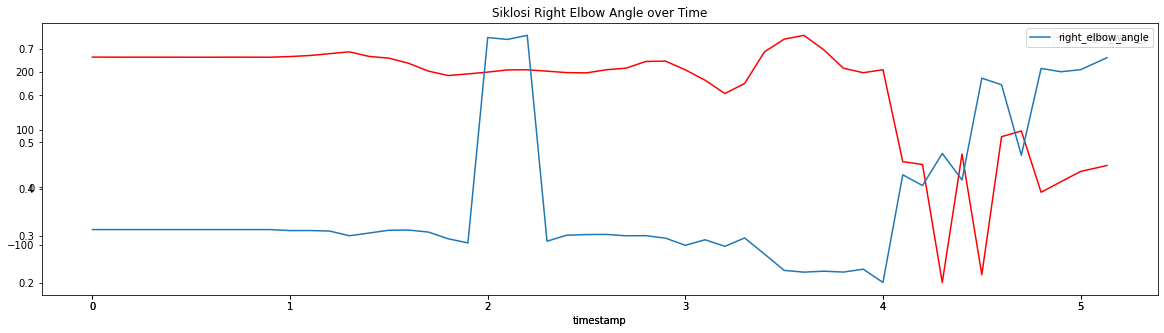

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(111, label="1")
annotationsPd.plot('timestamp', ['right_wrist_y'], figsize=(20, 5), ax=ax, color='red')
plt.title("Siklosi Right Elbow Angle over Time")
plt.savefig("s-right-arm-angle")
ax2=fig.add_subplot(111, label="2", frame_on=False)
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), ax=ax2)

#annotationsPd.plot.scatter('right_wrist_y', 'right_elbow_angle')

In [ ]:
id_token = "PASTE_YOUR_TOKEN_HERE"

__If you don't see an ID token after logging in, you probably need to allow cookies for that page in your browser. This will consistently happen if running in incognito mode. In Chrome, cookies can be enabled by clicking the eye icon to the far right of your URL tab.__

Now, you are able to analyze the snapshots. Write the `getAutoMLPrediction` function:

In [ ]:
from google.cloud import storage
import re
import logging
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def getAutoMLPrediction():
    responseList = []
    match = re.match(r'gs://([^/]+)/(.+)', snapshot_bucket_location)
    bucket_name = match.group(1)
    prefix = match.group(2)
    storage_client = storage.Client.from_service_account_json("./key.json")
    my_bucket = storage_client.bucket(bucket_name)
    for blob in my_bucket.list_blobs(prefix=str(prefix + "/")):
        if blob.name.endswith(".jpg"):
            logger.info("File location: {}".format(os.path.join('gs://',bucket_name, blob.name)))
            params = {}

            #[START] GSP666-API REQUEST
            url_lifetime = 3600  # Seconds in an hour
            serving_url = blob.generate_signed_url(expiration=url_lifetime, version='v4')
            # response = prediction_client.predict(model_full_id, payload, params)
            header = {'Authorization': 'Bearer ' + id_token}
            data = {"image_url" : serving_url,
                "compute_region": "us-central1",
                "model_id": "IOD5928674449107714048",
                }
            url = 'https://gsp666-api-kjyo252taq-uc.a.run.app/image'
            response = requests.post(url, json=data, headers=header)
            response_data = response.json()
            logger.info("response data from API")
            logger.info(response_data)
            #[END] GSP666-API REQUEST
            if "payload" in  response_data:
                responseList.append([obj['imageObjectDetection']['boundingBox']['normalizedVertices'] for obj in response_data['payload']])
            else:
                responseList.append({})

    return responseList

The `getAutoMLPredicion` function loops through your snapshots and generates a payload (the data variable) from the snapshot's url within the bucket, the compute region (AutoML predict only supports us-central1 at the moment), and the model ID of the pretrained model. The function uses the ID token you stored earlier to authorize this Cloud Run request to the model.

The response from the Cloud Run request is the response from the pretrained model that is exposed via Cloud Run. When you run the function, the logs will display the information in each response object.

With the __getAutoMLPrediciton__ function written, run it and assign its return value (the responses) to the coords variable:

In [ ]:
# Call the AutoML API--this could take a while!
coords = getAutoMLPrediction()

Don't be alarmed by snapshots that return empty responses. If the prediction score of the model was too low, it will return an empty response. In this case, this is usually because there is no lunge in some of the snapshots but can also be the result of the small margin of error the model has.

Now with the AutoML data, create an image to see what's actually going on:

In [ ]:
def makeFencingImage(filename, coords):
  im = Image.open(filename)
  im.thumbnail((im.width * 0.2, im.height * 0.2))
  draw = ImageDraw.Draw(im)
  for coord in coords:
    draw.rectangle([(coord[0]['x'] * im.width, coord[0]['y'] * im.height), coord[1]['x'] * im.width, coord[1]['y'] * im.height])
  return im

In [ ]:
imgs = [makeFencingImage('tmp/snapshots/' + filename, coord) for filename, coord in zip(snapshotFiles, coords) if 'jpg' in filename]
!mkdir snapshot_annotated
for idx, im in enumerate(imgs):
  plt.imshow(np.asarray(im))
  plt.savefig('snapshot_annotated/file%d.png' % idx)


Now that the lunge is tracked, you can compute it's position and then speed!

In [ ]:
# For simplicity, just plot the bottom left corner of the bounding box
# around the lunge
coord_x = [lunge[0]['x'] for frame in coords for lunge in frame]
coord_y = [1 - lunge[0]['y'] for frame in coords for lunge in frame]
timestamps = [x/20 for x in range(len(coord_x))] # 20 frames per second

Plot the lunge in space, and see how it leaves the hand and then flies across the court.

In [ ]:
plt.title("Position of fencer when lunging")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.scatter(coord_x, coord_y)
plt.savefig("lunge_position_x_y.png")

To determine the speed, look at the distance the lunge travels over time:

In [ ]:
plt.title("Y position of fencer when lunging over time")
plt.xlabel("seconds")
plt.ylabel("Y position")
plt.scatter(timestamps, coord_y)
plt.savefig("lunge_position_over_time.png")

You can see that 0.5 to 0.7 seconds is when the lunge occurs. So, to compute the speed, divide distance by time!

In [ ]:
# Get the first data point from 0.5 seconds
start_x = coord_x[timestamps.index(0.5)]
end_x = coord_x[-1]
start_y = coord_y[timestamps.index(0.5)]
end_y = coord_y[-1]

# Compute the Euclidean distance
distance = math.sqrt((start_x - end_x)**2 + (start_y - end_y)**2)
time = timestamps[-1] - 0.5

print(f"The speed of your lunge was {distance/time}")